In [5]:
import pandas as pd
import numpy as np
from datetime import datetime
# Geolocation lib
import geopy as gp
from geopy.distance import vincenty
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Define some global constants
SHOW_INFO = False
HOME_GPS = np.array([41.864080, -87.624100])
WORK_GPS = np.array([42.059570, -87.674778])
COMMUTE_MIN_TRIP_LEN = 1800 # Minimum trip length in seconds for daily commute trips
COMMUTE_MIN_DST_DIST = 2.0 # Minimum trip destination length in miles
COMMUTE_MAX_TRIP_DIST = 19.0 # Maximum trip distance in miles
CAR_FUEL_TANK_SIZE = 15.9 # Gallons
DATA_MIN_SAMP_SIZE = 300  # minimum trip length is about 5 minutes
DATA_MIN_MEAN_SPEED = 5.0  # minimum mean speed to determine if the speed data are valid

In [3]:
df = pd.read_csv('raw_logs.csv',header=0).groupby('session')
tripData = pd.DataFrame()
for session, sdf in df:
    dtObj = datetime.fromtimestamp(session/1000.0)
    timeStr = dtObj.strftime('%Y-%m-%d %H:%M:%S')
    
    # Sort by timestamp get the final average MPG for every trip (kff1205)
    sdf = sdf.sort_values('time')
    # Remove invalid values
    sdf = sdf[sdf.kc != 0]
    
    # Ignore session sample size is too small
    if len(sdf.kc.values) < DATA_MIN_SAMP_SIZE:
        continue
    
    # Trip duration
    sts = sdf.time.min()
    ets = sdf.time.max()
    diffTs = ets - sts
    tripLen = diffTs / 1000.0
    # GPS
    gpsLoc = np.array([sdf.kff1006.tolist(), sdf.kff1005.tolist()])
    distHome = np.array([vincenty(gpsLoc[:, 0], HOME_GPS).miles, vincenty(gpsLoc[:, -1], HOME_GPS).miles])
    distWork = np.array([vincenty(gpsLoc[:, 0], WORK_GPS).miles, vincenty(gpsLoc[:, -1], WORK_GPS).miles])
    # Trip distance
    tripDist = sdf.kff1204.max() * 0.62137119223733  # Km to Miles
    # Determine if this is a daily commute trip
    commuteTrip = tripLen > COMMUTE_MIN_TRIP_LEN and tripDist < COMMUTE_MAX_TRIP_DIST and (distHome.min() + distWork.min()) < COMMUTE_MIN_DST_DIST
    # Trip type
    tripType = "commute-" if commuteTrip else "other"
    if commuteTrip:
        tripType += "work2home" if commuteTrip and distHome[0] > distWork[0] else "home2work" 
    # Fuel Usage
    fuelUsed = sdf.kff1271.max() * 0.26417205124156 # L to Gal
    # MPG
    averageMPG = tripDist / fuelUsed
    # Ambient air temp
    airTempList = sdf.k46.tolist()
    airTempValid = np.std(airTempList) > 0
    meanAirTemp = np.nan
    if airTempValid:
        meanAirTemp = np.mean(airTempList)
    # Speed and moving statistics
    speed = sdf.kff1001.values * 0.621371
    meanSpeed = 3600.0 * tripDist / tripLen
    ## If the averaged speed from GPS is not too far from actual computed mean
    if np.abs(speed.mean() - meanSpeed) < DATA_MIN_MEAN_SPEED:
        idleRatio = 100.0 * np.count_nonzero(speed < 2) / len(speed)
        movingRatio = 100.0 - idleRatio
    else:
        idleRatio = np.nan
        movingRatio = np.nan
    
    # Dumps information
    if SHOW_INFO:
        print('session {0} ({1}), {2} records'.format(session, timeStr, len(sdf.index)))
        print("---------- Trip type: {0} ----------".format(tripType))
        # Print trip start and end timestamp
        stsStr = datetime.fromtimestamp(sts/1000.0).strftime('%Y-%m-%d %H:%M:%S')
        etsStr = datetime.fromtimestamp(ets/1000.0).strftime('%Y-%m-%d %H:%M:%S')
        print("\t|- Start {0}, end {1}".format(stsStr, etsStr))
        print("\t|- Duration {0} seconds ({1:.2f} minutes)".format(diffTs/1000.0, diffTs/60000.0))
        print("\t|- Distance {0:.2f} miles".format(tripDist))
        print("\t|- Fuel used {0:.3f} gal".format(fuelUsed))
        print("\t|- Average MPG {0:.3f}".format(averageMPG))
        if airTempValid:
            print("\t|- Ambient air temp {0:.2f} degree".format(meanAirTemp))
        if meanSpeed != np.nan:
            print("Mean speed = {0:.3f} MPH, idle ratio = {1:.3f}%".format(meanSpeed, idleRatio))
    else:
        print('Loading session {0} ({1}), {2} seconds ({3:.0f} minutes)'.format(session, timeStr, tripLen, tripLen/60))

    # Save session data
    sessionData = pd.DataFrame({
        'session': session,
        'sTS': sts,
        'eTS': ets,
        'weekday': dtObj.strftime('%a'),
        'airTemp': meanAirTemp,
        'commuteTrip': commuteTrip,
        'tripType': tripType,
        'duration': tripLen,
        'distance': tripDist,
        'fuelUsed': fuelUsed,
        'mpg': averageMPG,
        'idleRatio': idleRatio,
        'movingRatio': movingRatio,
        'meanSpeed': meanSpeed
    }, index=[0])
    sessionData.set_index('session', inplace=True)
    tripData = tripData.append(sessionData)
    
    # Key values
    ### Engine
    ##### k11     =  Throttle Position(Manifold)
    ##### kc      =  Engine RPM
    ##### k46     =  Ambient air temp
    ##### kff1271 =  Fuel used (trip)
    #
    ### Trip
    ##### kff1271 =  Fuel used (trip)
    ##### kff1204 =  Trip Distance
    ##### kff1205 =  Trip average MPG
    #
    ### GPS
    ##### kff1239 =  GPS Accuracy
    ##### kff1010 =  GPS Altitude
    ##### kff123b =  GPS Bearing
    ##### kff1006 =  GPS Latitude
    ##### kff1005 =  GPS Longitude

Loading session 1509673999804 (2017-11-02 20:53:19), 1672.964 seconds (28 minutes)
Loading session 1509715520133 (2017-11-03 08:25:20), 487.987 seconds (8 minutes)
Loading session 1509814879698 (2017-11-04 12:01:19), 462.987 seconds (8 minutes)
Loading session 1510237809601 (2017-11-09 08:30:09), 2658.962 seconds (44 minutes)
Loading session 1510269323150 (2017-11-09 17:15:23), 4439.999 seconds (74 minutes)
Loading session 1510286442413 (2017-11-09 22:00:42), 715.003 seconds (12 minutes)
Loading session 1510290674076 (2017-11-09 23:11:14), 881.999 seconds (15 minutes)
Loading session 1510350680589 (2017-11-10 15:51:20), 352.0 seconds (6 minutes)
Loading session 1510351896342 (2017-11-10 16:11:36), 642.0 seconds (11 minutes)
Loading session 1510356817421 (2017-11-10 17:33:37), 611.001 seconds (10 minutes)
Loading session 1510440698699 (2017-11-11 16:51:38), 444.0 seconds (7 minutes)
Loading session 1510583409805 (2017-11-13 08:30:09), 3019.718 seconds (50 minutes)
Loading session 151058

Loading session 1518100306875 (2018-02-08 08:31:46), 3086.999 seconds (51 minutes)
Loading session 1518129367228 (2018-02-08 16:36:07), 4467.998 seconds (74 minutes)
Loading session 1518184203509 (2018-02-09 07:50:03), 1138.986 seconds (19 minutes)
Loading session 1518217607184 (2018-02-09 17:06:47), 744.982 seconds (12 minutes)
Loading session 1518218904936 (2018-02-09 17:28:24), 559.0 seconds (9 minutes)
Loading session 1518306584623 (2018-02-10 17:49:44), 913.996 seconds (15 minutes)
Loading session 1518378376539 (2018-02-11 13:46:16), 1207.995 seconds (20 minutes)
Loading session 1518395614987 (2018-02-11 18:33:34), 899.997 seconds (15 minutes)
Loading session 1518445611885 (2018-02-12 08:26:51), 2543.988 seconds (42 minutes)
Loading session 1518460121597 (2018-02-12 12:28:41), 358.992 seconds (6 minutes)
Loading session 1518476422897 (2018-02-12 17:00:22), 4058.964 seconds (68 minutes)
Loading session 1518532226400 (2018-02-13 08:30:26), 3574.994 seconds (60 minutes)
Loading sessi

In [11]:
td.tail(1)

,airTemp,commuteTrip,distance,duration,eTS,fuelUsed,idleRatio,meanSpeed,movingRatio,mpg,sTS,tripType,weekday
session,,,,,,,,,,,,,
1520374035590,5.822423,True,16.167355,2762.999,1520376810367,0.591782,22.242315,21.064965,77.757685,27.319778,1520374047368,commute-work2home,Tue


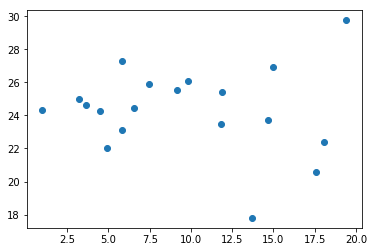

In [12]:
td = tripData[(tripData.commuteTrip == True) & (tripData.idleRatio > 0) & (tripData.airTemp > 0)]
plt.scatter(td.airTemp.values, td.mpg.values);